# Qur'an QA Retrieval Pipeline Starter Notebook

This notebook sketches out the end-to-end pipeline:
1. Data Preparation
2. Sparse (TF-IDF) Indexing & Retrieval
3. Dense (Embeddings + FAISS) Indexing & Retrieval
4. Retriever Fusion
5. Cross-Encoder Re-Ranking
6. No-Answer Detection
7. Answer Selection & Formatting
8. Evaluation & Metrics

---


In [1]:
#!pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 76.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [1]:
# 1. Imports and Setup
import os
import pandas as pd
import json
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# For dense retrieval
!pip install faiss-cpu
import faiss
from sentence_transformers import SentenceTransformer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 52.7 MB/s eta 0:00:00


In [4]:
# For cross-encoder reranking
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# For evaluation
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import numpy as np


Mount Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive/') # Standard mount point is /content/drive

Mounted at /content/drive/


## Evaluation Functions

Recall@K:   
- Definition: Was the correct passage found in the top K?  
- Good for: Checking if the retriever is “finding” the right info.

In [6]:
def recall_at_k(results, gold_map, k):
    hits = []
    for q, golds in gold_map.items():
        topk = [id for id, sim in sorted(results[q], key=lambda x: x[1], reverse=True)]
        hits.append(len(set(topk[:k]) & set(golds)) / len(golds))
    return sum(hits) / len(hits)

Precision@K:   
- Definition: Was the top K of the correct passages?  
- Good for: Checking if the retriever is selecting correct passages.

In [7]:
def precision_at_k(results, gold_map, k):
    """
    Calculates Precision@K for retrieval results.

    Args:
        results (dict): Dictionary of retrieval results, keyed by query,
                        with values as lists of (passage_id, score) tuples.
        gold_map (dict): Dictionary of gold standard answers, keyed by query,
                         with values as sets of correct passage_ids.
        k (int): The number of top retrieved passages to consider.

    Returns:
        float: The average Precision@K across all queries.
    """
    precisions = []
    for q, golds in gold_map.items():
        # Get the top K retrieved passage IDs for the current query
        topk = [id for id, sim in sorted(results[q], key=lambda x: x[1], reverse=True)][:k]

        # Count how many of the top K retrieved passages are in the gold set
        num_relevant_in_topk = len(set(topk) & set(golds))

        # Calculate precision for the current query
        # Avoid division by zero if k is 0 or no results are retrieved
        if k > 0 and len(topk) > 0:
             precision = num_relevant_in_topk / k
        else:
             precision = 0.0 # Precision is 0 if no passages are retrieved in the top K

        precisions.append(precision)

    # Calculate the average precision across all queries
    # Avoid division by zero if gold_map is empty
    if len(precisions) > 0:
        return sum(precisions) / len(precisions)
    else:
        return 0.0 # Return 0 if there are no queries to evaluate

Mean Reciprocal Rank (MRR).   
- Definition: Average of the reciprocal rank of the first correct result.  
- Good for: Ranking evaluation — high scores = gold is near top.  

In [8]:
def mrr(results, gold_map):
    scores = []
    for q, topk in results.items():
        golds = gold_map[q]
        for i, (pid, _) in enumerate(topk):
            if pid in golds:
                scores.append(1 / (i + 1))
                break
            else:
                scores.append(0)
    return sum(scores) / len(scores)

Rank Info:  
- For individual ranks of every question

In [9]:
def rank_positions(results, gold_map):
    q_ranks = {}
    for q, golds in gold_map.items():
        topk = [id for id, sim in sorted(results[q], key=lambda x: x[1], reverse=True)]
        rank = [topk.index(gold) if gold in topk else -1 for gold in golds ]
        q_ranks[q] = rank
    return q_ranks

## 2. Data Preparation

In [10]:
import re

def normalize_text(text):
    # Lowercase
    text = text.lower()

    # Remove non-alphabetic characters
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)

    # Collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

  def normalize_text_arabic(text):
    # Remove non-Arabic alphanumeric characters
    text = re.sub(r'[^\u0600-\u06FF0-9a-zA-Z\s]', '', text)
    return text

In [11]:
# Load Ayatec QA pairs
ayatec = pd.read_csv("/content/drive/MyDrive/IslamicEval/Data/preprocessed_questions_with_answers_train.csv")  # ensure columns: question, surah_number, ayah_start, ayah_end

# Load Qur'an + Tafseer passages
qbc = pd.read_csv("/content/drive/MyDrive/IslamicEval/Data/qpc_with_quran_translation_and_aljalalyn.csv")  # ensure columns: surah_number, ayah_start, ayah_end, english_passage, tafseer

# Load Arabic Qur'an + Tafseer passages
qbc_arab = pd.read_csv("/content/drive/MyDrive/IslamicEval/Data/Quran_in_arabic_with_aljalalyn_and_almuyassar_tafseer.csv")  # ensure columns: surah_number, ayah_start, ayah_end, english_passage, tafseer

# English
# Merge text fields
qbc['text'] = qbc['english_quran_passage'] + "\n" + qbc['aljalalyn_tafseer']
qbc["text"] = qbc["text"].fillna("")
qbc['norm_text'] = qbc['text'].apply(normalize_text)

# Create unique IDs
qbc['passage_id'] = qbc.apply(lambda r: f"{r.surah_number}:{r.ayah_start}-{r.ayah_end}", axis=1)

# Arabic
# Merge text fields
qbc_arab['text'] = qbc_arab['passage'] + "\n" + qbc_arab['aljalalyn_tafseer']
qbc_arab["text"] = qbc_arab["text"].fillna("")
qbc_arab['norm_text'] = qbc['text'].apply(normalize_text_arabic)

# Create unique IDs
qbc_arab['passage_id'] = qbc_arab.apply(lambda r: f"{r.surah_number}:{r.ayah_start}-{r.ayah_end}", axis=1)

# Train-test split for Ayatec so that every question is either train or test
# Get the unique questions
unique_questions = ayatec['english'].unique()

# Split the unique questions into train and test sets
train_questions, test_questions = train_test_split(
    unique_questions,
    test_size=0.1, # Adjust the test size as needed
    random_state=42, # for reproducibility
    # No stratify needed here if you just want to split unique questions randomly
    # If you need to stratify based on some property of the question, you'd need a list
    # or array of that property corresponding to the unique questions.
)

# Filter the original ayatec DataFrame to create train_q and test_q based on the split questions
train_q = ayatec[ayatec['english'].isin(train_questions)].copy()
test_q = ayatec[ayatec['english'].isin(test_questions)].copy()

Group Gold Answers

In [23]:
from collections import defaultdict

def group_gold_answers(df, q_col='english', a_col='answer'):
    grouped = defaultdict(set)
    for _, row in df.iterrows():
        qid = row[q_col]
        pid = row[a_col]
        grouped[qid].add(pid)
    return grouped

In [26]:
# Group gold answers
gold_map = group_gold_answers(ayatec,q_col='english')

# Group gold answers arabic
gold_map_arab = group_gold_answers(ayatec, q_col="arabic")

Creating dataframe for question level evaluation

In [14]:
eval_df = ayatec.groupby("english")["answer"].nunique().loc[ayatec["english"].unique()].reset_index(name="count_answers").rename(columns={"english":"question"})

In [15]:
eval_df

,question,count_answers
0,Who were the people of Shu'ayb?,4
1,Who were the people of Moses?,17
2,Who built the Kaaba?,1
3,Which prophet is known for patience?,2
4,Who was the guardian of Lady Mary?,1
...,...,...
205,What is the most profitable trade mentioned in...,5
206,Can Satan mislead all people?,8
207,Who are the ten promised Paradise?,1
208,Is Islam a multi‑cultural and multi‑ethnic rel...,2


## 3. Sparse Retrieval (TF-IDF)

In [39]:
# Fit once (after loading and processing qbc)
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(qbc['text'].tolist())


# TODO: build index from qbc['text'], using passage_id as docid
# e.g., using SimpleIndexer or Elasticsearch client


In [40]:
# 3.2 Searching
def tfidf_search(query, top_k=10):
    #query = normalize_text(query)
    query_vec = tfidf_vectorizer.transform([query])
    scores = cosine_similarity(query_vec, tfidf_matrix).flatten()
    top_idxs = scores.argsort()[::-1][:top_k]
    return [(qbc.iloc[i]['passage_id'], float(scores[i])) for i in top_idxs]


In [41]:
tfidf_search("Who were the people of Moses?")

[('28:44-46', 0.44452858052815414),
 ('28:14-19', 0.437905549638332),
 ('5:20-26', 0.35025910181306),
 ('18:60-77', 0.3486591737880143),
 ('10:79-86', 0.34466180089701187),
 ('10:87-89', 0.331338532326257),
 ('14:5-8', 0.3205291416439311),
 ('26:23-40', 0.31706044778621556),
 ('17:101-104', 0.29915250735447013),
 ('23:45-50', 0.29870600831140837)]

In [42]:
# Run retrieval per unique question
sparse_results = {q: tfidf_search(q, 50) for q in gold_map}

# Evaluate
print("TF-IDF Recall@20:", recall_at_k(sparse_results, gold_map, 50))
print("TF-IDF Precision@10:", precision_at_k(sparse_results, gold_map, 10))

TF-IDF Recall@20: 0.4210273266551465
TF-IDF Precision@10: 0.08285714285714284


In [43]:
eval_df["recall_sparse"] = pd.Series(({q: 1-(ranks.count(-1)/len(ranks)) for q, ranks in rank_positions(sparse_results, gold_map).items()}),name="recall_sparse").reset_index(drop=True)

TODO:
- use BM25 instead of tfidf.
  - BM25 using pysirin was very hard to install on colab or even local
  - BM25 from elastic search needed docker service running (not possible on drive)
- change parameters of tfidf, n-gram, limmtizing words, ...
- Analyze difficult questions
- How about using non Aya/Hadith answer from chatgpt together with the question ?

## 4. Dense Retrieval (Embeddings + FAISS)

In [30]:
# 4.1 Encode passages
embed_model_arab = SentenceTransformer('FDSRashid/QulBERT')  # or other embedding
passage_embeddings_arab = embed_model_arab.encode(qbc_arab["text"].tolist(), show_progress_bar=True)

# 4.2 Build FAISS index
d = passage_embeddings_arab.shape[1]
faiss_index = faiss.IndexFlatIP(d)
faiss.normalize_L2(passage_embeddings_arab)
faiss_index.add(passage_embeddings_arab)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/40 [00:00<?, ?it/s]

In [31]:
# 4.3 Searching
def dense_search_arab(query, top_k=10):
    q_emb = embed_model_arab.encode([query])
    faiss.normalize_L2(q_emb)
    scores, idxs = faiss_index.search(q_emb, top_k)
    results = [(qbc_arab.iloc[i]['passage_id'], float(scores[0][j])) for j,i in enumerate(idxs[0])]
    return results

In [32]:
dense_search_arab("من هم قوم شعيب؟", top_k=10)

[('15:78-79', 0.4009245038032532),
 ('50:12-15', 0.38162386417388916),
 ('21:74-75', 0.3635067343711853),
 ('69:9-12', 0.3556203246116638),
 ('38:12-16', 0.3279416561126709),
 ('34:15-19', 0.32347989082336426),
 ('37:123-132', 0.3219572901725769),
 ('72:1-7', 0.3219206929206848),
 ('7:109-112', 0.3206075429916382),
 ('2:243-245', 0.31730028986930847)]

In [33]:
# Run retrieval per unique question
dense_results_arab = {q: dense_search_arab(q, 50) for q in gold_map_arab}

# Evaluate
print("Dense Recall@20:", recall_at_k(dense_results_arab, gold_map_arab, 50))
print("Dense Precision@10:", precision_at_k(dense_results_arab, gold_map_arab, 10))

Dense Recall@20: 0.36114732127392474
Dense Precision@10: 0.07142857142857134


In [81]:
eval_df["recall_dense"] = pd.Series(({q: 1-(ranks.count(-1)/len(ranks)) for q, ranks in rank_positions(dense_results_arab, gold_map_arab).items()}),name="recall_dense").reset_index(drop=True)

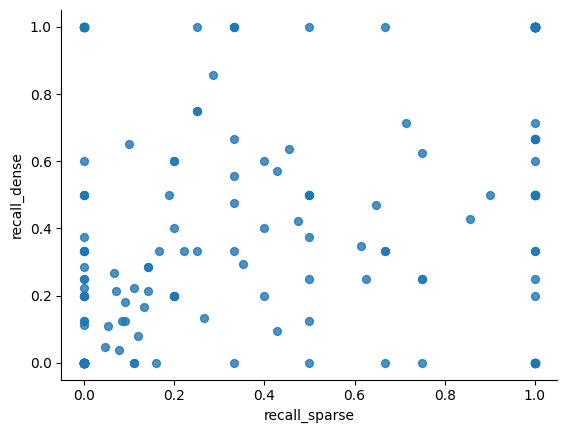

In [82]:
from matplotlib import pyplot as plt
eval_df.plot(kind='scatter', x='recall_sparse', y='recall_dense', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

TODO:
- use diffrent embedding model
- Analyze difficult questions

## 5. Retriever Fusion

In [83]:
def hybrid_retrieve(query_e, query_a, k1=10, k2=10, final_k=20):
    sparse = tfidf_search(query_e, k1)
    dense = dense_search_arab(query_a, k2)
    # TODO: normalize scores and merge, then select top final_k
    # Simple placeholder: just concatenate for now
    all_cand = sparse + dense
    # TODO: implement proper fusion
    return all_cand[:final_k]

In [84]:
# Run retrieval per unique question
hyprid_results_arab = {q_e: hybrid_retrieve(q_e, q_a, k1=50, k2=50, final_k=100) for q_e, q_a in zip(gold_map, gold_map_arab)}

# Evaluate
print("hyprid Recall@20:", recall_at_k(hyprid_results_arab, gold_map, 100))
print("hyprid Precision@10:", precision_at_k(hyprid_results_arab, gold_map, 10))

hyprid Recall@20: 0.5765716022119163
hyprid Precision@10: 0.0857142857142857


In [85]:
eval_df["recall_hyprid"] = pd.Series(({q: 1-(ranks.count(-1)/len(ranks)) for q, ranks in rank_positions(hyprid_results_arab, gold_map).items()}),name="recall_hyprid").reset_index(drop=True)

In [86]:
(eval_df["recall_dense"] > eval_df["recall_sparse"]).mean()

0.30952380952380953

In [87]:
(eval_df["recall_sparse"] > eval_df["recall_dense"]).mean()

0.2571428571428571

TODO:
- make diffrent merging method than just concat
- Analyse how sparse VS dense performing in question

## 6. Cross-Encoder Re-Ranking

In [ ]:
# 6.1 Prepare data for fine-tuning
# Format: question \t passage_text \t label (1 or 0)
# TODO: generate positives and negatives from train_q

# 6.2 Fine-tune cross-encoder
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
sparse_results_test = {q:pl for q,pl in sparse_results.items() if test_q["english"].str.contains(q).any()}
dense_results_test = {q:pl for q,pl in dense_results.items() if test_q["english"].str.contains(q).any()}

/tmp/ipython-input-35-146393211.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  sparse_results_test = {q:pl for q,pl in sparse_results.items() if test_q["english"].str.contains(q).any()}
/tmp/ipython-input-35-146393211.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  dense_results_test = {q:pl for q,pl in dense_results.items() if test_q["english"].str.contains(q).any()}


In [ ]:
sparse_results_train = {q:pl for q,pl in sparse_results.items() if train_q["english"].str.contains(q).any()}
dense_results_train = {q:pl for q,pl in dense_results.items() if train_q["english"].str.contains(q).any()}

/tmp/ipython-input-36-366074852.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  sparse_results_train = {q:pl for q,pl in sparse_results.items() if train_q["english"].str.contains(q).any()}
/tmp/ipython-input-36-366074852.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  dense_results_train = {q:pl for q,pl in dense_results.items() if train_q["english"].str.contains(q).any()}


In [ ]:
from collections import defaultdict

def prepare_cross_encoder_data(qa_dataframe, sparse_results, dense_results, qbc_dataframe, num_negatives=10):
    """
    Prepares data for fine-tuning a cross-encoder model.

    Args:
        qa_dataframe (pd.DataFrame): DataFrame containing question-answer pairs
                                     with columns 'english' (question) and 'answer' (passage_id).
        sparse_results (dict): Dictionary of sparse retrieval results,
                               keyed by question with a list of (passage_id, score) tuples.
        dense_results (dict): Dictionary of dense retrieval results,
                              keyed by question with a list of (passage_id, score) tuples.
        qbc_dataframe (pd.DataFrame): DataFrame containing passage information
                                      with columns 'passage_id' and 'text'.
        num_negatives (int): The number of negative samples to generate per question.

    Returns:
        list: A list of dictionaries, each containing 'question', 'passage', and 'label'.
    """
    training_data = []

    # Group qa_dataframe by question to get all gold answers for each unique question
    gold_answers_map = defaultdict(list)
    for _, row in qa_dataframe.iterrows():
        gold_answers_map[row['english']].append(row['answer'])

    # Generate positive and negative examples for each unique question
    for question, gold_passage_ids in gold_answers_map.items():
        # Generate positive examples
        for gold_passage_id in gold_passage_ids:
            # Find the corresponding passage text
            passage_row = qbc_dataframe.loc[qbc_dataframe['passage_id'] == gold_passage_id]
            if not passage_row.empty:
                passage_text = passage_row['text'].values[0]
                training_data.append({'question': question, 'passage': passage_text, 'label': 1})
            else:
                print(f"Warning: Gold Passage ID {gold_passage_id} not found in qbc_dataframe for question: {question}.")

        # Generate negative examples from sparse and dense retrieval candidates
        sparse_candidates = [pid for pid, score in sparse_results.get(question, [])]
        dense_candidates = [pid for pid, score in dense_results.get(question, [])]

        # Combine candidates and remove the gold answers
        all_candidates = list(set(sparse_candidates + dense_candidates))
        negative_candidate_ids = [pid for pid in all_candidates if pid not in gold_passage_ids]

        # Randomly sample some negative passages from these candidates
        current_num_negatives = min(num_negatives, len(negative_candidate_ids))
        if current_num_negatives > 0:
            sampled_negative_ids = np.random.choice(negative_candidate_ids, current_num_negatives, replace=False)

            for neg_pid in sampled_negative_ids:
                passage_row = qbc_dataframe.loc[qbc_dataframe['passage_id'] == neg_pid]
                if not passage_row.empty:
                    neg_passage_text = passage_row['text'].values[0]
                    training_data.append({'question': question, 'passage': neg_passage_text, 'label': 0})
                else:
                     print(f"Warning: Negative Passage ID {neg_pid} not found in qbc_dataframe for question: {question}.")


    return training_data

# training data:
training_data = prepare_cross_encoder_data(train_q, sparse_results_train, dense_results_train, qbc)

# test data :
test_evaluation_data = prepare_cross_encoder_data(test_q, sparse_results_test, dense_results_test, qbc)

In [ ]:
from datasets import Dataset

# Function to tokenize the data
def tokenize_function(examples):
    # Tokenize the question and passage pairs
    # The tokenizer expects lists of strings
    return tokenizer(examples['question'], examples['passage'], padding="max_length", truncation=True)

# Convert list of dicts to Hugging Face Dataset objects
train_dataset = Dataset.from_dict({'question': [x['question'] for x in training_data],
                                   'passage': [x['passage'] for x in training_data],
                                   'label': [x['label'] for x in training_data]})

test_dataset = Dataset.from_dict({'question': [x['question'] for x in test_evaluation_data],
                                  'passage': [x['passage'] for x in test_evaluation_data],
                                  'label': [x['label'] for x in test_evaluation_data]})


# Apply the tokenization function to the datasets
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format to PyTorch tensors
tokenized_train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'token_type_ids', 'label'])
tokenized_test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'token_type_ids', 'label'])

Map:   0%|          | 0/2941 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

In [ ]:
import os
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np # Import numpy
import torch # Import torch

# Path where you want to save your checkpoints (change this to your desired Drive path)
checkpoint_output_dir = "/content/drive/MyDrive/IslamicEval/Model/cross_encoder_checkpoints"

# Ensure the directory exists
os.makedirs(checkpoint_output_dir, exist_ok=True)

# Find the latest checkpoint directory to resume from, if it exists
latest_checkpoint = None
if os.path.exists(checkpoint_output_dir):
    checkpoints = [d for d in os.listdir(checkpoint_output_dir) if os.path.isdir(os.path.join(checkpoint_output_dir, d)) and d.startswith("checkpoint-")]
    if checkpoints:
        # Sort by checkpoint number to find the latest
        checkpoints.sort(key=lambda x: int(x.split('-')[1]))
        latest_checkpoint_path = os.path.join(checkpoint_output_dir, checkpoints[-1])
        print(f"Found latest checkpoint: {latest_checkpoint_path}")
        # When resuming, you pass the *path* to the checkpoint directory
        latest_checkpoint = latest_checkpoint_path
    else:
        print("No checkpoints found, starting training from scratch.")
else:
    print("Checkpoint directory does not exist, starting training from scratch.")


# Define training arguments with saving enabled and evaluation strategy
training_args = TrainingArguments(
    output_dir=checkpoint_output_dir, # Use the checkpoint directory as output
    num_train_epochs=10,             # Total number of training epochs
    per_device_train_batch_size=24,  # Batch size
    warmup_steps=500,                # Warmup steps
    weight_decay=0.01,               # Weight decay
    logging_dir='./logs',            # Logging directory
    logging_steps=10,
    eval_strategy="epoch",        # Evaluate at the end of each epoch
    save_strategy="epoch",           # Save at the end of each epoch
    save_steps=10,                   # Save every 10 epoch
    save_total_limit=2,              # Keep only the 3 most recent checkpoints
    load_best_model_at_end=True, # Load the best model based on evaluation metric
    metric_for_best_model="precision", # Metric to monitor for best model
    # remove_unused_columns=False, # Add if needed to prevent issues with dataset columns
)

# Function to compute metrics (moved here to be in the same cell for clarity)
def compute_metrics(p):
    """Computes accuracy, precision, recall, and f1 for a sequence classification model."""
    preds = np.argmax(p.predictions, axis=1)
    # Assuming binary classification where label 1 is the positive class
    precision = precision_score(p.label_ids, preds, average='binary', zero_division=0)
    recall = recall_score(p.label_ids, preds, average='binary', zero_division=0)
    f1 = f1_score(p.label_ids, preds, average='binary', zero_division=0)
    accuracy = accuracy_score(p.label_ids, preds)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset, # Use tokenized dataset
    eval_dataset=tokenized_test_dataset, # Use tokenized dataset
    compute_metrics=compute_metrics # Add compute_metrics function
)

# Start or resume training
trainer.train(resume_from_checkpoint=latest_checkpoint)

# After training is complete (or resumed), you can save the final model weights separately if desired
# trainer.save_model("/content/drive/MyDrive/IslamicEval/Model/cross_encoder_final_model")

No checkpoints found, starting training from scratch.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.305000,0.412375,0.802589,0.710145,0.823529,0.762646
2,0.374000,0.381880,0.802589,0.733871,0.764706,0.748971
3,0.264200,0.500519,0.799353,0.771429,0.680672,0.723214
4,0.335400,0.515802,0.741100,0.653543,0.697479,0.674797
5,0.214700,0.602734,0.766990,0.737374,0.613445,0.669725
6,0.175400,0.513578,0.802589,0.719697,0.798319,0.756972
7,0.105500,0.905836,0.773463,0.769231,0.588235,0.666667
8,0.016200,1.152198,0.786408,0.757282,0.655462,0.702703
9,0.016900,1.309858,0.770227,0.750000,0.605042,0.669767
10,0.001000,1.363085,0.773463,0.757895,0.605042,0.672897


TrainOutput(global_step=1230, training_loss=0.17381059158767567, metrics={'train_runtime': 3171.2068, 'train_samples_per_second': 9.274, 'train_steps_per_second': 0.388, 'total_flos': 7738096138137600.0, 'train_loss': 0.17381059158767567, 'epoch': 10.0})

In [ ]:
# Save the fine-tuned model
output_dir = "/content/drive/MyDrive/IslamicEval/Model/cross_encoder_finetuned"
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model saved to {output_dir}")

Model saved to /content/drive/MyDrive/IslamicEval/Model/cross_encoder_finetuned


In [ ]:
# 6.3 Re-rank retrieval results
def cross_encode_rerank(query, candidates, top_k=10):
    # candidates is a list of (passage_id, score)
    # Get the passage text for each candidate
    candidate_passages = []
    candidate_ids = [cid for cid, _ in candidates]

    for cid in candidate_ids:
        passage_row = qbc.loc[qbc['passage_id'] == cid]
        if not passage_row.empty:
            candidate_passages.append(passage_row['text'].values[0])
        else:
            candidate_passages.append("") # Handle missing passage text

    # Create pairs for the cross-encoder
    features = tokenizer([query] * len(candidate_passages), candidate_passages,  padding=True, truncation=True, return_tensors="pt")

    # Move tensors to the same device as the model
    features = {k: v.to(model.device) for k, v in features.items()}


    # Get scores from the cross-encoder
    with torch.no_grad():
        outputs = model(**features)
        # The output is logits, usually the second logit corresponds to the positive class (label=1)
        scores = outputs.logits[:, 1].cpu().numpy()

    # Pair candidate IDs with their new scores and sort
    reranked_results = sorted(zip(candidate_ids, scores), key=lambda x: x[1], reverse=True)

    return reranked_results[:top_k]

import torch # Ensure torch is imported for model device
# Load the model for reranking
model_path = "/content/drive/MyDrive/IslamicEval/Model/cross_encoder_finetuned"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval() # Set model to evaluation mode


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Example usage: Rerank the top 20 from the hybrid retrieval
reranked_results = {}
for q, candidates in hyprid_results.items():
    reranked_results[q] = cross_encode_rerank(q, candidates, top_k=10) # Rerank top 100 to top 10

In [ ]:


# Evaluate reranked results
print("\nReranked Recall@20:", recall_at_k(reranked_results, gold_map, 20))
print("Reranked Precision@5:", precision_at_k(reranked_results, gold_map, 5))

eval_df["recall_reranked"] = pd.Series(({q: 1-(ranks.count(-1)/len(ranks)) for q, ranks in rank_positions(reranked_results, gold_map).items()}),name="recall_reranked").reset_index(drop=True)



Reranked Recall@20: 0.4548637107122292
Reranked Precision@5: 0.24952380952380984



Original Dense Results:
[('7:85-93', 0.6909956914041752), ('15:78-79', 0.4488935598973097), ('26:176-191', 0.3825999757315458), ('29:36-37', 0.35671561474191726), ('28:22-28', 0.30247801217127224), ('11:84-88', 0.27722150464051326), ('11:89-95', 0.275796739026336), ('50:12-15', 0.1811615584035765), ('22:42-46', 0.16306576519570418), ('38:12-16', 0.16298562581898224), ('15:78-79', 0.4009245038032532), ('50:12-15', 0.38162386417388916), ('21:74-75', 0.3635067343711853), ('69:9-12', 0.3556203246116638), ('38:12-16', 0.3279416561126709), ('34:15-19', 0.32347989082336426), ('37:123-132', 0.3219572901725769), ('72:1-7', 0.3219206929206848), ('7:109-112', 0.3206075429916382), ('2:243-245', 0.31730028986930847)]

Reranked Results:
[('34:15-19', 0.617436408996582), ('72:1-7', 0.23657628893852234), ('7:85-93', -0.2510208785533905), ('28:22-28', -0.26373717188835144), ('26:176-191', -0.2749198079109192), ('11:89-95', -0.2789953351020813), ('11:84-88', -0.2936299741268158), ('29:36-37', -0.366773

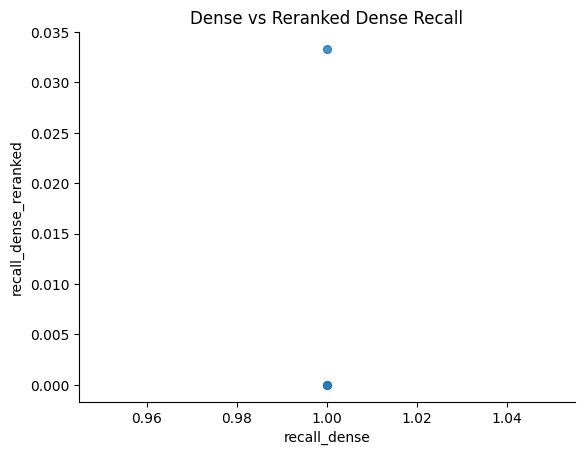

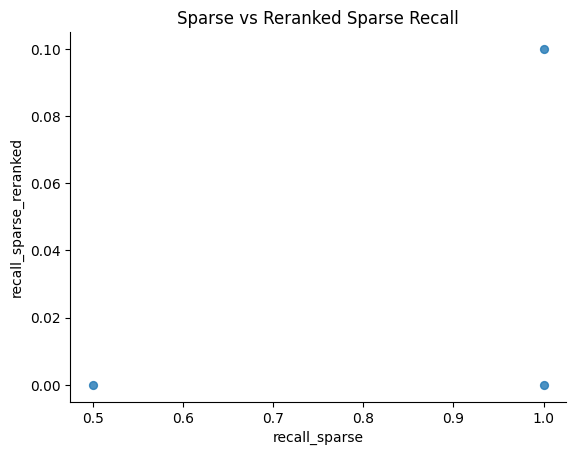

KeyError: 'recall_hybrid'

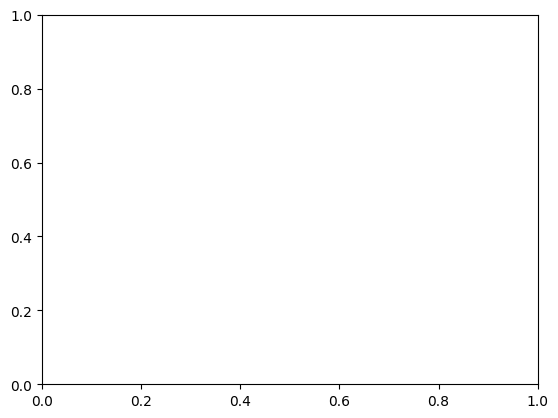

In [ ]:
# 6.3 Re-rank retrieved passages
# Apply the trained cross-encoder to re-rank the top_k passages from retrieval.

def rerank_results(query, retrieved_passages, cross_encoder_tokenizer, cross_encoder_model):
    """
    Reranks a list of retrieved passages for a given query using a cross-encoder.

    Args:
        query (str): The user query.
        retrieved_passages (list): A list of (passage_id, score) tuples from a retriever.
                                   The score is not used by the cross-encoder but kept for context.
        cross_encoder_tokenizer: The tokenizer for the cross-encoder model.
        cross_encoder_model: The trained cross-encoder model.

    Returns:
        list: A list of (passage_id, reranked_score) tuples, sorted by reranked_score.
    """
    if not retrieved_passages:
        return []

    # Prepare input pairs for the cross-encoder: (query, passage_text)
    # We need the actual passage text for each passage_id
    passage_texts = []
    passage_ids = []
    for pid, _ in retrieved_passages:
        passage_row = qbc.loc[qbc['passage_id'] == pid]
        if not passage_row.empty:
            passage_texts.append(passage_row['text'].values[0])
            passage_ids.append(pid)
        else:
            print(f"Warning: Passage ID {pid} not found in qbc_dataframe for re-ranking.")
            # Handle cases where passage might not be found (though it should be if from qbc)

    # Prepare inputs for the cross-encoder
    features = cross_encoder_tokenizer([query] * len(passage_texts), passage_texts,  padding=True, truncation=True, return_tensors="pt")

    # Move inputs to the same device as the model
    features = {k: v.to(cross_encoder_model.device) for k, v in features.items()}

    # Get model predictions (logits)
    cross_encoder_model.eval() # Set model to evaluation mode
    with torch.no_grad(): # Disable gradient calculation
        outputs = cross_encoder_model(**features)

    # Get scores (logits for the positive class - assuming binary classification)
    # If your model outputs probabilities directly, adjust this.
    # For sequence classification with num_labels=2, outputs.logits will have shape [batch_size, 2]
    # We want the logit/score for the positive class (usually index 1)
    reranked_scores = outputs.logits[:, 1].tolist()

    # Combine passage_ids with their new scores
    reranked_results = list(zip(passage_ids, reranked_scores))

    # Sort by the new reranked scores in descending order
    reranked_results.sort(key=lambda x: x[1], reverse=True)

    return reranked_results

import torch

# Ensure the model is on a device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Example of using the rerank function
# Let's take a sample query and use the dense retrieval results as input
sample_query = "Who were the people of Shu'ayb?"
retrieved_candidates = hybrid_retrieve(sample_query)

reranked_candidates = rerank_results(sample_query, retrieved_candidates, tokenizer, model)

print("\nOriginal Dense Results:")
print(retrieved_candidates)

print("\nReranked Results:")
print(reranked_candidates)


# Apply reranking to the results for evaluation (e.g., test set results)
# We need the sparse/dense/hybrid results specifically for the test questions
# (assuming test_q contains the test questions)

# First, filter the full sparse/dense/hybrid results to only include test questions
test_question_set = set(test_q['english'].unique())

sparse_results_test_eval = {q: results for q, results in sparse_results.items() if q in test_question_set}
dense_results_test_eval = {q: results for q, results in dense_results.items() if q in test_question_set}
hybrid_results_test_eval = {q: results for q, results in hyprid_results.items() if q in test_question_set}

# Now apply reranking to these test results
reranked_sparse_results = {}
for q, results in sparse_results_test_eval.items():
    reranked_sparse_results[q] = rerank_results(q, results, tokenizer, model)

reranked_dense_results = {}
for q, results in dense_results_test_eval.items():
     reranked_dense_results[q] = rerank_results(q, results, tokenizer, model)

reranked_hybrid_results = {}
for q, results in hybrid_results_test_eval.items():
     reranked_hybrid_results[q] = rerank_results(q, results, tokenizer, model)


# Evaluate the reranked results using the same metrics (Recall@K, MRR)
# For evaluation, we need the gold answers for the test questions.
gold_map_test = group_gold_answers(test_q)


print("\nReranked Sparse Results Evaluation:")
print("Recall@20:", recall_at_k(reranked_sparse_results, gold_map_test, 20))
print("MRR:", mrr(reranked_sparse_results, gold_map_test))

print("\nReranked Dense Results Evaluation:")
print("Recall@20:", recall_at_k(reranked_dense_results, gold_map_test, 20))
print("MRR:", mrr(reranked_dense_results, gold_map_test))

print("\nReranked Hybrid Results Evaluation:")
print("Recall@20:", recall_at_k(reranked_hybrid_results, gold_map_test, 20))
print("MRR:", mrr(reranked_hybrid_results, gold_map_test))

# Optional: Update eval_df with reranked results' recall
# Need to match test questions in eval_df. Assuming eval_df has all questions, filter it.
eval_df_test = eval_df[eval_df['question'].isin(test_question_set)].copy()

eval_df_test["recall_sparse_reranked"] = pd.Series(({q: 1-(ranks.count(-1)/len(ranks)) for q, ranks in rank_positions(reranked_sparse_results, gold_map_test).items()}),name="recall_sparse_reranked").reset_index(drop=True)
eval_df_test["recall_dense_reranked"] = pd.Series(({q: 1-(ranks.count(-1)/len(ranks)) for q, ranks in rank_positions(reranked_dense_results, gold_map_test).items()}),name="recall_dense_reranked").reset_index(drop=True)
eval_df_test["recall_hybrid_reranked"] = pd.Series(({q: 1-(ranks.count(-1)/len(ranks)) for q, ranks in rank_positions(reranked_hybrid_results, gold_map_test).items()}),name="recall_hybrid_reranked").reset_index(drop=True)

print("\nEvaluation DataFrame for Test Questions with Reranking:")
print(eval_df_test)


## 7. No-Answer Detection


You can add a special `[NO_ANSWER]` label during fine-tuning or train a separate classifier on `(question, best_candidate)` pairs.


## 8. Answer Selection & Formatting

In [ ]:
def select_answer(question):
    cands = hybrid_retrieve(question)
    reranked = rerank(question, cands)
    best_pid, best_score = reranked[0]
    # TODO: apply no-answer threshold
    meta = qbc.set_index('passage_id').loc[best_pid, ['surah_number','ayah_start','ayah_end']]
    text = qbc.set_index('passage_id').loc[best_pid, 'text']
    return {
        'surah': int(meta['surah_number']),
        'ayah_start': int(meta['ayah_start']),
        'ayah_end': int(meta['ayah_end']),
        'text': text,
        'score': best_score
    }


## 9. Final Evaluation & Metrics

In [ ]:
def evaluate(test_questions):
    # test_questions: DataFrame with gold surah, ayah_start, ayah_end
    preds, golds = [], []
    for _, row in test_questions.iterrows():
        out = select_answer(row['question'])
        preds.append((out['surah'], out['ayah_start'], out['ayah_end']))
        golds.append((row['surah_number'], row['ayah_start'], row['ayah_end']))
    # Compute exact match
    em = np.mean([p==g for p,g in zip(preds,golds)])
    print(f"Exact Match: {em:.3f}")

# Run evaluation on our test set
# evaluate(test_q)


## Load arabic data

### Subtask:
Load the `qbc_arab` DataFrame.


**Reasoning**:
The subtask is to load and explore the `qbc_arab` DataFrame. The DataFrame is already loaded, so I will display its head and columns to confirm its availability and contents.



In [16]:
display(qbc_arab.head())
print(qbc_arab.columns)

,passage,surah_number,ayah_start,ayah_end,aljalalyn_tafseer,almuyassar_tafseer
0,بسم الله الرحمن الرحيم. الحمد لله رب العالمين....,1,1,4,بسم الله الرحمن الرحيم الحمد لله جملة خبرية قص...,سورة الفاتحة سميت هذه السورة بالفاتحة؛ لأنه يف...
1,إياك نعبد وإياك نستعين. اهدنا الصراط المستقيم.,1,5,6,إيَّاك نعبد وإياك نستعين أي نخصك بالعبادة من ت...,إنا نخصك وحدك بالعبادة، ونستعين بك وحدك في جمي...
2,صراط الذين أنعمت عليهم غير المغضوب عليهم ولا ا...,1,7,7,صراط الَّذين أنعمت عليهم بالهداية ويبدل من الذ...,طريق الذين أنعمت عليهم من النبيين والصدِّيقين ...
3,الم. ذلك الكتاب لا ريب فيه هدى للمتقين.,2,1,2,الم الله أعلم بمراده بذلك. ذلك أي هذا الكتاب ا...,هذه الحروف وغيرها من الحروف المقطَّعة في أوائل...
4,الذين يؤمنون بالغيب ويقيمون الصلاة ومما رزقناه...,2,3,5,الذين يؤمنون يصدِّقون بالغيب بما غاب عنهم من ا...,وهم الذين يُصَدِّقون بالغيب الذي لا تدركه حواس...


Index(['passage', 'surah_number', 'ayah_start', 'ayah_end',
       'aljalalyn_tafseer', 'almuyassar_tafseer'],
      dtype='object')


## Choose arabic embedding model

### Subtask:
Select an appropriate pre-trained Arabic Sentence Transformer model (like one from the Arabert or Camel families).


## Encode arabic passages

### Subtask:
Use the chosen model to generate embeddings for the Arabic passages in `qbc_arab`.


**Reasoning**:
Generate embeddings for the Arabic passages using the chosen Sentence Transformer model.



In [72]:
def normalize_text_arabic(text):
    # Remove non-Arabic alphanumeric characters
    text = re.sub(r'[^\u0600-\u06FF0-9a-zA-Z\s]', '', text)
    return text

# Merge text fields
qbc_arab['text'] = qbc_arab['passage'] + "\n" + qbc_arab['aljalalyn_tafseer']
qbc_arab["text"] = qbc_arab["text"].fillna("")

# Create unique IDs
qbc_arab['passage_id'] = qbc_arab.apply(lambda r: f"{r.surah_number}:{r.ayah_start}-{r.ayah_end}", axis=1)

In [74]:
# 4.1 Encode passages
embed_model_arab = SentenceTransformer('FDSRashid/QulBERT')  # or other embedding
passage_embeddings_arab = embed_model_arab.encode(qbc_arab["text"].tolist(), show_progress_bar=True)

# 4.2 Build FAISS index
d = passage_embeddings_arab.shape[1]
faiss_index = faiss.IndexFlatIP(d)
faiss.normalize_L2(passage_embeddings_arab)
faiss_index.add(passage_embeddings_arab)

Batches:   0%|          | 0/40 [00:00<?, ?it/s]

In [75]:
# 4.3 Searching
def dense_search_arab(query, top_k=10):
    q_emb = embed_model_arab.encode([query])
    faiss.normalize_L2(q_emb)
    scores, idxs = faiss_index.search(q_emb, top_k)
    results = [(qbc_arab.iloc[i]['passage_id'], float(scores[0][j])) for j,i in enumerate(idxs[0])]
    return results

In [76]:
dense_search_arab("من هم قوم شعيب؟", top_k=10)

[('7:85-93', 0.6326546669006348),
 ('29:36-37', 0.5879510641098022),
 ('15:78-79', 0.5858718156814575),
 ('22:42-46', 0.5855753421783447),
 ('29:24-27', 0.5276505947113037),
 ('37:133-138', 0.5207889676094055),
 ('26:160-175', 0.5176262259483337),
 ('29:38-40', 0.5091129541397095),
 ('11:89-95', 0.49712374806404114),
 ('50:12-15', 0.4916177988052368)]

In [77]:
# Run retrieval per unique question
dense_results_arab = {q: dense_search_arab(q, 50) for q in gold_map_arab}

# Evaluate
print("Dense Recall@20:", recall_at_k(dense_results_arab, gold_map_arab, 50))
print("Dense Precision@10:", precision_at_k(dense_results_arab, gold_map_arab, 10))

Dense Recall@20: 0.42688056091948184
Dense Precision@10: 0.0857142857142857


Fusion with sparse

In [47]:
def SE_DA_hybrid_retrieve(query_e, query_a, k1=10, k2=10, final_k=20):
    sparse = tfidf_search(query_e, k1)
    dense = dense_search_arab(query_a, k2)
    # TODO: normalize scores and merge, then select top final_k
    # Simple placeholder: just concatenate for now
    all_cand = sparse + dense
    # TODO: implement proper fusion
    return all_cand[:final_k]

In [58]:
# Run retrieval per unique question
hyprid_results_arab = {q_e: SE_DA_hybrid_retrieve(q_e, q_a, k1=50, k2=50, final_k=100) for q_e, q_a in zip(gold_map, gold_map_arab)}

# Evaluate
print("hyprid Recall@20:", recall_at_k(hyprid_results_arab, gold_map, 100))
print("hyprid Precision@10:", precision_at_k(hyprid_results_arab, gold_map, 10))

hyprid Recall@20: 0.5758144852972363
hyprid Precision@10: 0.08142857142857142


In [ ]:
# Example usage with your sparse results:
# print("TF-IDF Precision@10:", precision_at_k(sparse_results, gold_map, 10))

# Example usage with your dense results:
# print("Dense Precision@10:", precision_at_k(dense_results, gold_map, 10))

# Example usage with your hybrid results:
# print("Hybrid Precision@10:", precision_at_k(hyprid_results, gold_map, 10))

# Example usage with your reranked results:
# print("Reranked Precision@10:", precision_at_k(reranked_results, gold_map, 10))

In [ ]:
!pip install numpy==1.26.4

# Note: After running this cell, you need to restart your Colab runtime
# (Runtime -> Restart runtime) and then re-run all cells from the beginning.